In [1]:
import os
import sys

sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src.data.components import normalize_tensor
from sklearn import preprocessing
from src.utils.preprocessing import LogitScaler

2023-11-26 23:33:01.835245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 23:33:02.569731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
filepath = "/beegfs/desy/user/sommerhm/generative_challenge_2023/outerdata_kfold_1.npy"

In [4]:
data = np.load(filepath)

In [5]:
print(data.shape)

(344531, 5)


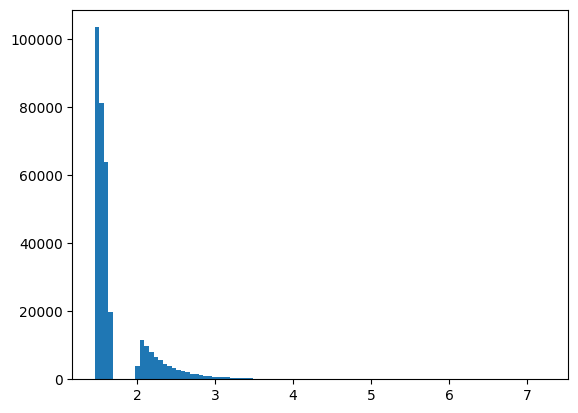

In [6]:
plt.hist(data[:,0], bins=100)
plt.show()

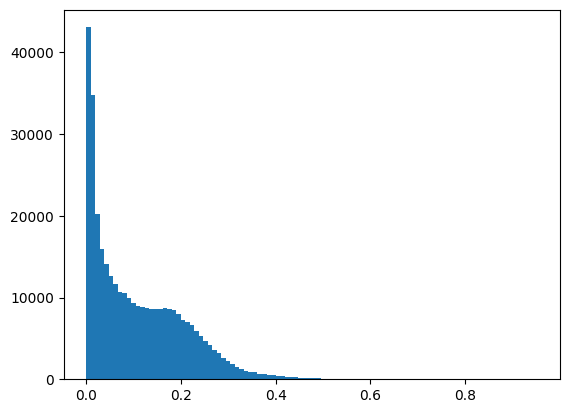

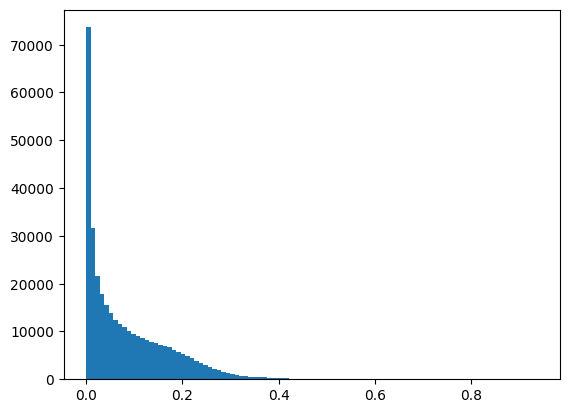

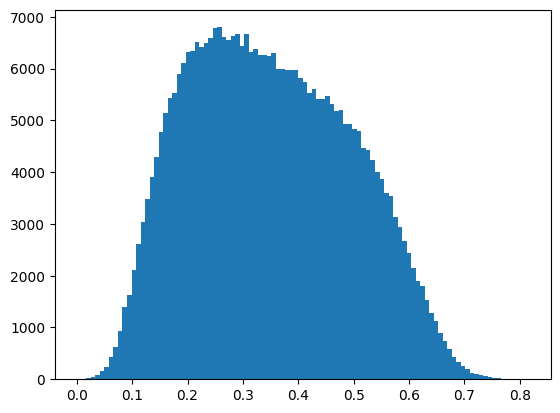

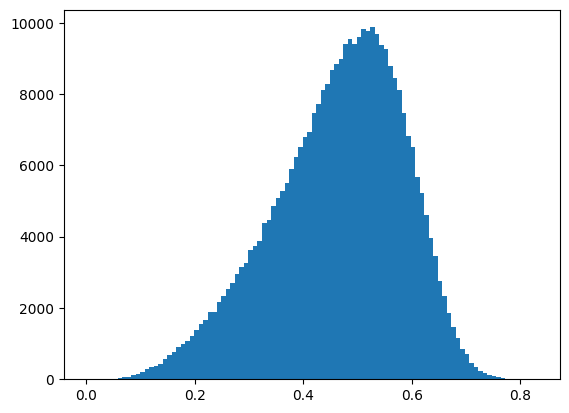

In [7]:
for i in range(1,5):
    plt.hist(data[:,i], bins=100)
    plt.show()

In [8]:
means = np.mean(data, axis=0)
stds = np.std(data, axis=0)
normalized_data_1 = normalize_tensor(
    np.copy(data), means, stds, sigma=1
)
print(means)
print(stds)

[1.7247276  0.10920091 0.08457768 0.34899586 0.46429163]
[0.39565107 0.09759869 0.08697253 0.14400777 0.11977484]


In [9]:
scaler = preprocessing.StandardScaler().fit(data)
print(scaler.mean_)
print(scaler.scale_)
normalized_data_2 = scaler.transform(data)

[1.72462664 0.10920248 0.08458071 0.34899656 0.46429606]
[0.39564909 0.09760222 0.08697604 0.14401363 0.11977993]


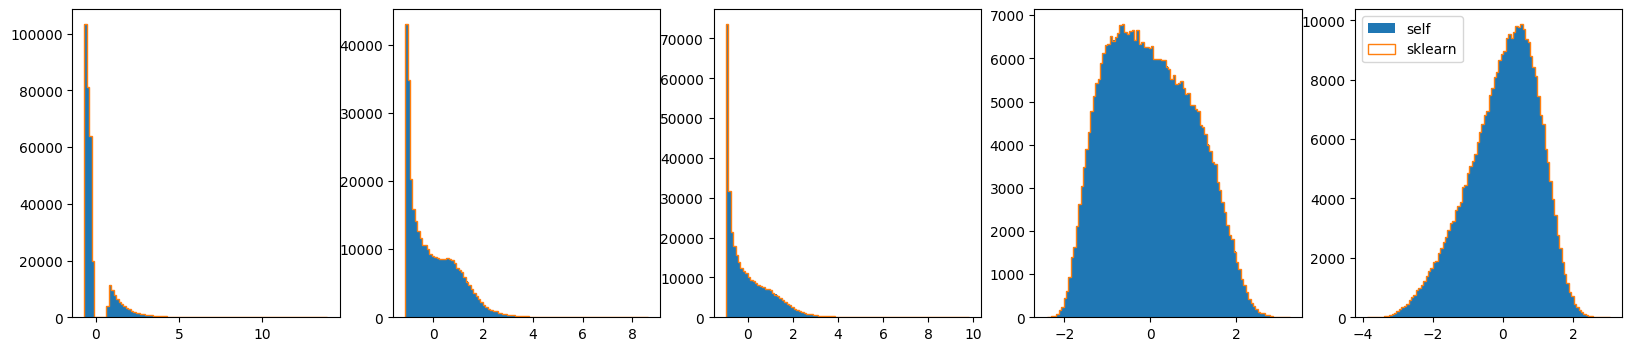

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    hist = ax[i].hist(normalized_data_1[:, i], bins=100, label="self")
    ax[i].hist(normalized_data_2[:, i], bins=hist[1], label="sklearn", histtype="step")
plt.legend()
    
plt.show()


In [11]:
from sklearn.pipeline import make_pipeline


scaler = make_pipeline(LogitScaler(), preprocessing.StandardScaler()).fit(data)
processed_data = scaler.transform(data)

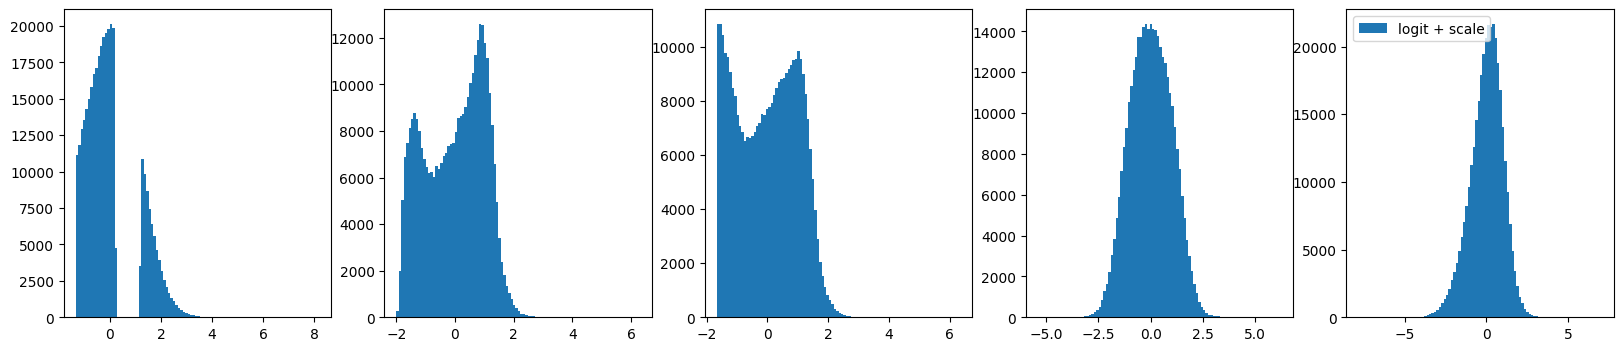

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    hist = ax[i].hist(processed_data[:, i], bins=100, label="logit + scale")
plt.legend()
    
plt.show()

In [13]:
data_back = scaler.inverse_transform(processed_data)

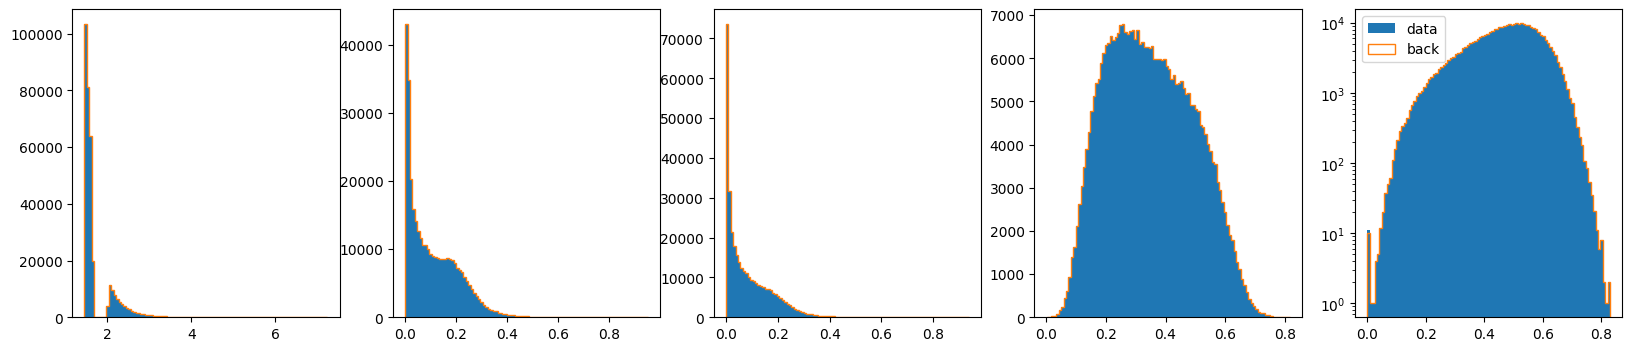

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    hist = ax[i].hist(data[:, i], bins=100, label="data")
    ax[i].hist(data_back[:, i], bins=hist[1], label="back", histtype="step")
plt.legend()
plt.yscale("log")
plt.show()

# Evaluation

In [98]:
import hydra
import torch
from omegaconf import OmegaConf
from os.path import join
from src.utils.data_generation import generate_data_v2
from src.utils.plotting import (
    apply_mpl_styles,)

In [99]:
apply_mpl_styles()

In [16]:
folder = "/beegfs/desy/user/ewencedr/deep-learning/logs/gen_challenge_flow_matching_jet_features/runs/2023-11-26_23-07-38/"

load config

In [17]:
cfg_backup_file = join(folder, "config.yaml")
# load everything from experiment config
with hydra.initialize(version_base=None, config_path="../configs/"):
    if os.path.exists(cfg_backup_file):
        print("config file already exists --> loading from run directory")
    else:
        raise FileNotFoundError("config file not found")
cfg = OmegaConf.load(cfg_backup_file)

config file already exists --> loading from run directory


instantiate model and data module

In [18]:
datamodule = hydra.utils.instantiate(cfg.data)
model = hydra.utils.instantiate(cfg.model)

datamodule.setup()

tensor train: torch.Size([1033593, 4])
mask train: torch.Size([1033593, 1])
tensor conditioning train: torch.Size([1033593, 1])
tensor train dtype torch.float32
mask train dtype torch.float32
tensor conditioning train dtype torch.float32
Tensor train: 0
Mask train: 0
Tensor conditioning train: 0
Train dataset size: 1033593
Validation dataset size: 344531
Test dataset size: 344527


load checkpoint

In [19]:
ckpt = join(folder, "checkpoints", "last-EMA.ckpt")
model = model.load_from_checkpoint(ckpt)

### Generate Conditioning

In [33]:
data_load0_sr = np.load("/beegfs/desy/user/sommerhm/generative_challenge_2023/innerdata_kfold_0.npy")
data_load1_sr = np.load("/beegfs/desy/user/sommerhm/generative_challenge_2023/innerdata_kfold_1.npy")
data_load2_sr = np.load("/beegfs/desy/user/sommerhm/generative_challenge_2023/innerdata_kfold_2.npy")
data_load3_sr = np.load("/beegfs/desy/user/sommerhm/generative_challenge_2023/innerdata_kfold_3.npy")
data_load4_sr = np.load("/beegfs/desy/user/sommerhm/generative_challenge_2023/innerdata_kfold_4.npy")
data_load_list_sr = [
    data_load0_sr,
    data_load1_sr,
    data_load2_sr,
    data_load3_sr,
    data_load4_sr,
]
innerdata_train = np.concatenate(
    [
        data_load_list_sr[i]
        for i in range(5)
        if i not in datamodule.hparams.val_sets + datamodule.hparams.test_sets
    ],
    axis=0,
)

In [42]:
test_data_number = datamodule.hparams.test_sets[0]
innerdata_test = np.load(f"/beegfs/desy/user/sommerhm/generative_challenge_2023/innerdata_kfold_{test_data_number}.npy")

In [34]:
# fitting a KDE for the mass distribution based on the inner training set

# we also perform a logit first to stretch out the hard boundaries
from sklearn.neighbors import KernelDensity


m_scaler = LogitScaler()
m_train = m_scaler.fit_transform(innerdata_train[:, 0:1])

kde_model = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_model.fit(m_train)

# now let's sample 4x the number of training data
m_samples = kde_model.sample(4*len(m_train)).astype(np.float32)
m_samples = m_scaler.inverse_transform(m_samples)

In [35]:
print(m_samples.shape)

(2133732, 1)


pre-process mjj samples for use as conditioning

In [37]:
m_conditioning = datamodule.preprocessing_pipeline_cond.transform(m_samples)

### Generate Samples

In [48]:
torch.manual_seed(1111)
data, generation_time = generate_data_v2(
    model,
    num_jet_samples=len(m_conditioning),
    batch_size=2048,
    cond=torch.Tensor(m_conditioning),
    preprocessing_pipeline=datamodule.preprocessing_pipeline,
    ode_solver="midpoint",
    ode_steps=25,
)

Generating data (2133732 samples). Device: cuda


  0%|          | 0/1041 [00:00<?, ?it/s]

100%|██████████| 1041/1041 [01:02<00:00, 16.60it/s]


In [84]:
samples = np.concatenate([m_samples, data], axis=1)#[:len(innerdata_train)]

In [85]:
print(samples.shape)

(2133732, 5)


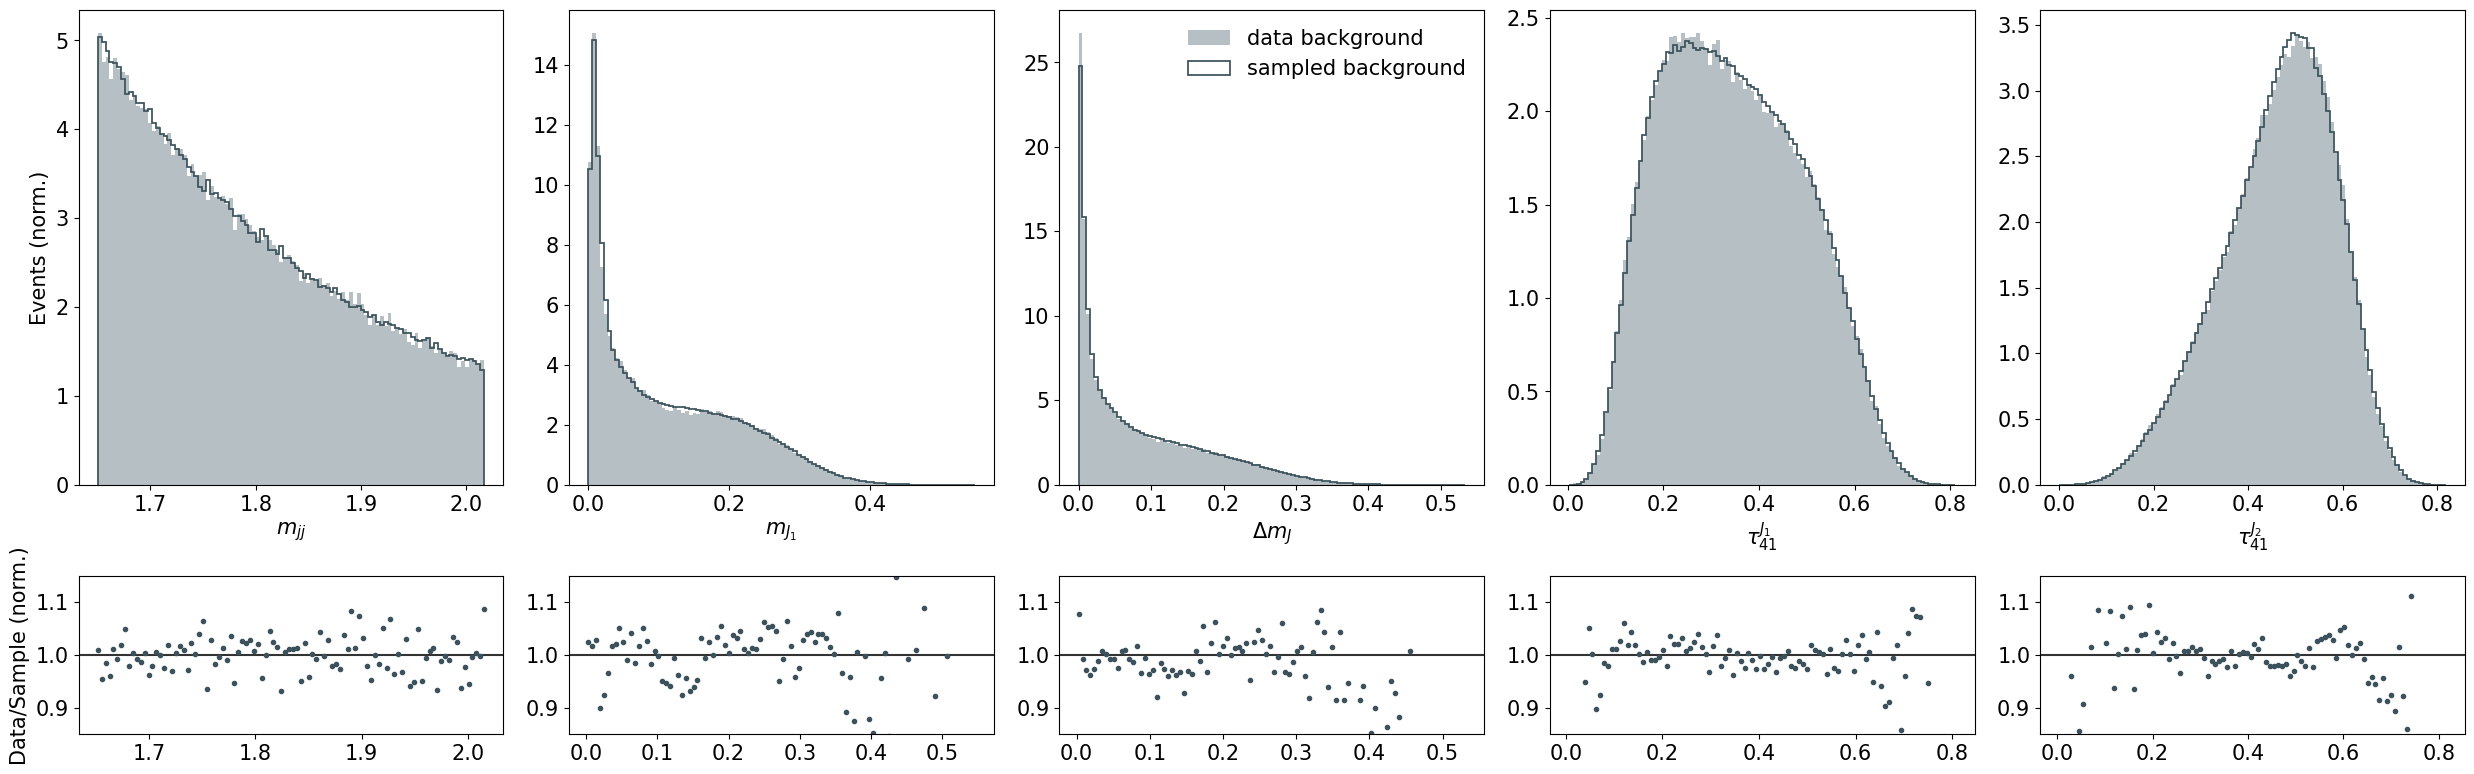

In [114]:
# comparing samples to inner background (idealized sanity check)
label_map = {
    "0": r"$m_{jj}$",
    "1": r"$m_{J_1}$",
    "2": r"$\Delta m_J$",
    "3": r"$\tau_{41}^{J_1}$",
    "4": r"$\tau_{41}^{J_2}$",
}
fig, ax = plt.subplots(2, 5, figsize=(25, 8),gridspec_kw={"height_ratios": [3, 1]})
for i in range(5):
    hist_data = ax[0,i].hist(innerdata_test[:,i],
                             bins=100, label="data background",
                             density=True, histtype="stepfilled")
    binning = hist_data[1]
    hist_samples = ax[0,i].hist(samples[:, i],
                 bins=binning, label="sampled background",
                 density=True, histtype="step")
    data_hist = hist_data[0]
    sample_hist = hist_samples[0]
    data_scale_factor = np.sum(data_hist) * np.diff(binning)
    sample_scale_factor = np.sum(sample_hist) * np.diff(binning)
    if i == 2:
        ax[0,i].legend(loc="best", frameon=False)
    #ax[i].set_ylim(0, plt.gca().get_ylim()[1] * 1.2)
    ax[0,i].set_xlabel(f"{label_map[str(i)]}")
    
    with np.errstate(divide='ignore', invalid='ignore'):
        ax[1,i].axhline(1., color="black", linestyle="-", alpha=0.8)
        next(ax[1,i]._get_lines.prop_cycler)
        ax[1,i].errorbar(0.5*(binning[:-1] + binning[1:]), data_hist / sample_hist * sample_scale_factor / data_scale_factor, linestyle="none", marker=".")#, yerr=np.sqrt(data_hist)/sample_hist * sample_scale_factor / data_scale_factor)
        ax[1,i].set_ylim(0.85, 1.15)
    if i == 0:
        ax[0,i].set_ylabel("Events (norm.)")
        ax[1,i].set_ylabel("Data/Sample (norm.)")
plt.tight_layout()
plt.show()


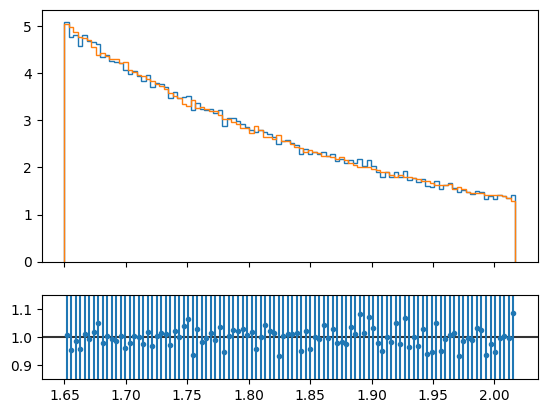

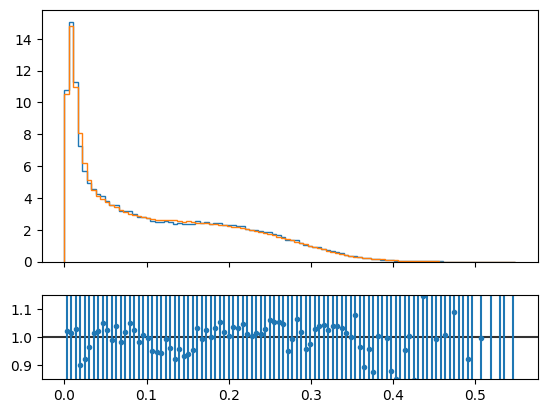

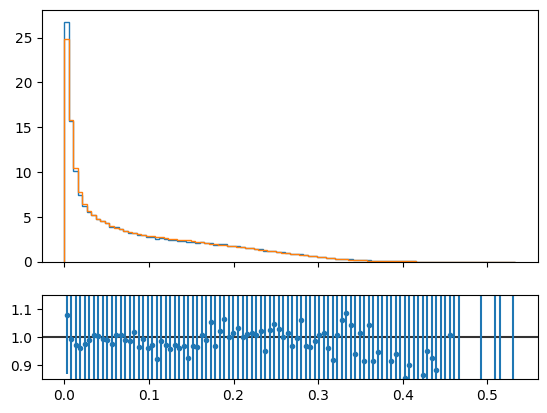

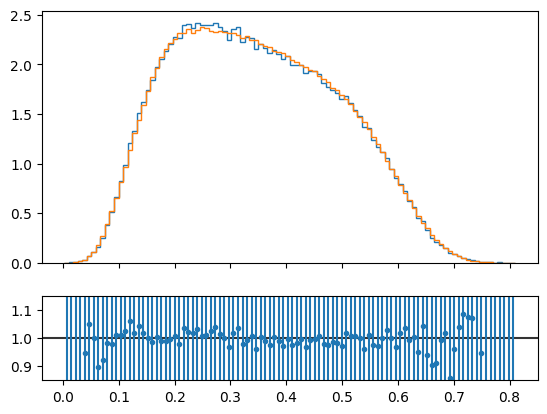

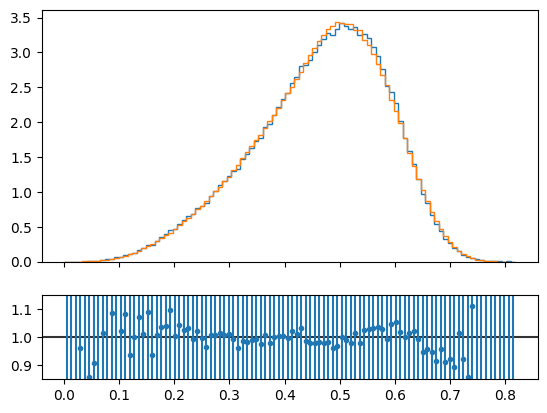

In [92]:
for i in range(5):
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True)
    hist_data = ax1.hist(innerdata_test[:,i],
                             bins=100, label="data background",
                             density=True, histtype="step")
    binning = hist_data[1]
    hist_samples = ax1.hist(samples[:, i],
                 bins=binning, label="sampled background",
                 density=True, histtype="step")
    data_hist = hist_data[0]
    sample_hist = hist_samples[0]
    #ax1.errorbar(0.5*(binning[:-1] + binning[1:]), data_hist/data_scale_factor, yerr=np.sqrt(data_hist)/data_scale_factor, fmt="none", color=data_color)
    sample_scale_factor = sum(sample_hist) * np.diff(binning)
    data_scale_factor = sum(data_hist) * np.diff(binning)
    #print(sample_scale_factor, data_scale_factor)
    with np.errstate(divide='ignore', invalid='ignore'):
        ax2.axhline(1., color="black", linestyle="-", alpha=0.8)
        ax2.errorbar(0.5*(binning[:-1] + binning[1:]), data_hist / sample_hist * sample_scale_factor / data_scale_factor, linestyle="none", marker=".", yerr=np.sqrt(data_hist)/sample_hist * sample_scale_factor / data_scale_factor)
        ax2.set_ylim(0.85, 1.15)
    

In [ ]:
# make mismodeling plots

from matplotlib import cm
plt.style.use('dark_background')

n_clsf = 3

data_color = "white"
sample_color = "yellow"
clsf_colors = cm.viridis(np.linspace(0.1, 1, n_clsf))

inner_bkg = innerdata_test[innerdata_test[:, -1] == 0, :]

# loop over classifiers
selected_bkgs = []
inner_scaler_ = StandardScaler()
inner_scaler_.fit(clsf_train_data[:, 1:-1])
for i in range(n_clsf):
    classifier_savedir_ = f"test_bed_classifiers/torch_fullbkg_0/classifier_{i}/"
    classifier_model_ = NeuralNetworkClassifier(save_path=classifier_savedir_,
                                                n_inputs=clsf_train_data[:, 1:-1].shape[1])
    classifier_model_.load_best_model()
    preds_ = classifier_model_.predict(inner_scaler_.transform(inner_bkg[:, 1:-1])).flatten()
    anomaly_threshold_ = np.percentile(preds_, 99)
    selected_bkgs.append(inner_bkg[preds_ > anomaly_threshold_])

for i in range(5):

    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True)
    _, binning, _ = ax1.hist(inner_bkg[:, i],
                             bins=40, label="data background",
                             density=True, histtype="step",
                             color=data_color)
    for j in range(n_clsf):
        _ = ax1.hist(selected_bkgs[j][:, i],
                     bins=binning, label=f"run {j}",
                     density=True, histtype="step",
                     color=clsf_colors[j])

    data_hist = np.histogram(inner_bkg[:, i],
                             bins=binning, density=False)[0]
    sample_hist = np.histogram(samples[:, i],
                               bins=binning, density=False)[0]

    sample_scale_factor = sum(sample_hist) * np.diff(binning)
    data_scale_factor = sum(data_hist) * np.diff(binning)

    ax1.errorbar(0.5*(binning[:-1] + binning[1:]), data_hist/data_scale_factor, yerr=np.sqrt(data_hist)/data_scale_factor, fmt="none", color=data_color)

    ax1.set_ylabel("Events (norm.)")
    ax1.set_yscale("log")
    ax1.legend(loc="upper right", ncol=2, frameon=False)
    y_scale_modifier = 16 if i > 0 else 1.5
    ax1.set_ylim(None, y_scale_modifier*ax1.get_ylim()[1])

    ax2.set_xlabel("feature {}".format(i))
    ax2.set_ylabel("Data/Sample (norm.)")
    ax2.grid(axis="y", alpha=0.5)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        ax2.axhline(1., color="w", linestyle="-", alpha=0.8)
        ax2.errorbar(0.5*(binning[:-1] + binning[1:]), data_hist / sample_hist * sample_scale_factor / data_scale_factor, color=sample_color, linestyle="none", marker=".", yerr=np.sqrt(data_hist)/sample_hist * sample_scale_factor / data_scale_factor)
    ax2.set_ylim(0.85, 1.15)

    plt.savefig(f"./legacy_cathode_plots/sample_quality_full/cls_and_samples_feature{i}.png", dpi=300)

    plt.show()